In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib import algos, helpers, envs
from lib.helpers import np_exclude
import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import copy
from tqdm import tqdm

import matplotlib
%config InlineBackend.figure_formats = ['svg']

In [3]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
})

In [4]:
np.set_printoptions(precision=5, suppress=True)

In [5]:
n_ep = 5000
epsilon = 0.9
# alpha_max, alpha_min, alpha_decay = 0.9, 1e-15, 1e-3
# alpha = lambda ep: alpha_min + (alpha_max-alpha_min)*np.exp(-alpha_decay*(ep))
# alpha = 0.1
gamma = 0.9

## Algorithms

### LSPI

In [6]:
# Model-based least-squares policy iteration
# using linear least-squares fixed-point approximation
# P: (nS*nA, dSA)
# R: (nS*nA,)
# X: (nS*nA, nS)
def LSPI_impl(P, R, X, γ, w_init=None, max_iter=100):
    _, dSA = X.shape
    nS, nA = env.nS, env.nA
    
    w_history = []

    if w_init is not None:
        w = w_init.copy()
    else:
        w = np.zeros((dSA,))

    w_history.append(w)
    
    for k in range(max_iter):
        π_w = (X @ w).reshape((nS, nA)).argmax(axis=1)

        Pi_w = np.zeros((nS, nS, nA))
        for s in range(nS):
            Pi_w[s,s,π_w[s]] = 1

        Pi_w = Pi_w.reshape((nS, -1))

        A = X.T @ (X - γ * P @ Pi_w @ X)
        b = X.T @ R
        w_ = np.linalg.pinv(A) @ b

        if np.isclose(w, w_).all():
            w_history.append(w_)
            break

        w = w_
        w_history.append(w)
    
    return w, w_history

In [8]:
# LSPI using one-hot state-action featurization
def LSPI_onehot(
    env, γ,
    w_init=None,
    max_iter=100,
):
    P, R, X = env.featurize(factored=False)
    return LSPI_impl(P, R, X, γ, w_init=w_init, max_iter=max_iter)

In [9]:
# LSPI using factored-action featurization (state is still equivalent of one-hot)
def LSPI_factored(
    env, γ,
    w_init=None,
    max_iter=100,
):
    P, R, X = env.featurize(factored=True)
    return LSPI_impl(P, R, X, γ, w_init=w_init, max_iter=max_iter)

### FactoredQ

In [10]:
class FactoredQ(object):
    def __init__(self, nSs, nAs):
        self.nSs = nSs
        self.nAs = nAs
        self.nS = nS = np.product(nSs)
        self.nA = nA = np.product(nAs)
        self.V0 = np.zeros((self.nS))
        self.Aj = [np.zeros((self.nS, nAj)) for nAj in self.nAs] # first column of each Aj[j] should always be zero
    
    def __getitem__(self, key):
        if isinstance(key, tuple):
            s, a = key
            return self.V0[s] + sum(self.Aj[j][s, a[j]] for j in range(len(self.nAs)))
        else: # assume only s is provided
            s = key
            Aj_all = np.zeros(self.nAs)
            for j in range(len(self.nAs)):
                Aj_all += np.expand_dims(self.Aj[j][s], axis=tuple([i for i in range(len(self.nAs)) if i != j]))
            return self.V0[s] + Aj_all
    
    def update(self, key, value, alpha):
        s, a = key
        Q_target = value
        
        # compute values
        new_V0s = Q_target - sum(self.Aj[j][s, a[j]] for j in range(len(self.nAs)))
        Ajsaj = np.zeros(len(self.nAs))
        for j in range(len(self.nAs)):
            if a[j] == 0: continue
            Ajsaj[j] = Q_target - self.V0[s] - sum(self.Aj[i][s, a[i]] for i in range(len(self.nAs)) if i != j)
        
        # update values
        self.V0[s] = (1-alpha) * self.V0[s] + alpha * new_V0s
        for j in range(len(self.nAs)):
            if a[j] == 0: continue
            self.Aj[j][s, a[j]] = (1-alpha) * self.Aj[j][s, a[j]] + alpha * Ajsaj[j]


def qlearn_factored(
    env, n_episodes, behavior_policy, gamma, alpha=0.1, epsilon=1.0, 
    Q_init=None, memory=None, save_Q=0, use_tqdm=True,
):
    if not callable(epsilon):
        epsilon_func = lambda episode: epsilon
    else:
        epsilon_func = epsilon
    
    if not callable(alpha): # step size
        alpha_ = alpha
        alpha = lambda episode: alpha_
    
    Q = FactoredQ(env.nSs, env.nAs)
    if Q_init is not None:
        Q = copy.deepcopy(Q_init)
    
    Gs = []
    Qs = [copy.deepcopy(Q)]
    TD_errors = []
    memory_buffer = []
    
    for episode in tqdm(range(n_episodes), disable=(not use_tqdm)):
        G = 0
        t = 0
        np.random.seed(episode)
        env.seed(episode)
        env.reset()
        S = env.s
        done = False
        while not done: # S is not a terminal state
            p = behavior_policy(np.reshape(Q[S],(1,-1)), dict(epsilon=epsilon_func(episode)))[0]
            A = np.random.choice(env.nA, p=p)
            
            AA = env.encode_action(A) # A // 2, A % 2
            
            S_, R, done, info = env.step(A)
            memory_buffer.append((S, A, R, S_, done))
            TD_errors.append(R + gamma * Q[S_].max() - Q[S,AA])
            
            # Perform update
            ##Q_new = Q[S,AA] + alpha(episode) * (R + gamma * Q[S_].max() - Q[S,AA])
            ##Q[S,AA] = Q_new
            
            Q_target = R + gamma * Q[S_].max()
            Q.update((S, AA), Q_target, alpha(episode))
            
            S = S_
            G = G + (gamma ** t) * R
            t = t + 1
            if save_Q: Qs.append(copy.deepcopy(Q))
        Gs.append(G)
    
    return Q, {
        'Gs': np.array(Gs), # cumulative reward for each episode
        'Qs': Qs, # history of all Q-values per update
        'TD_errors': np.array(TD_errors), # temporal difference error for each update
        'memory': memory_buffer, # all trajectories/experience, tuples of (s,a,r,s', done)
    }


## Environments

### Base MDP class

In [11]:
import gym
from gym.envs.toy_text import discrete
import numpy as np

class MDP_Env(discrete.DiscreteEnv):
    def __init__(self, p_transition, p_reward, S_terminal, isd=None):
        nS, nA, _ = p_transition.shape
        if isd is None:
            isd = np.ones(nS)
            isd = isd / isd.sum()
        
        if len(p_reward.shape) == 1:
            p_reward = np.tile(p_reward, (nS, nA, 1))
        if len(p_reward.shape) == 2:
            p_reward = np.repeat(p_reward, nS).reshape((nS, nA, nS))
        
        P = {s : {a : [] for a in range(nA)} for s in range(nS)}
        for s in range(nS):
            for a in range(nA):
                for s_ in range(nS):
                    if p_transition[s,a,s_] > 0:
                        P[s][a].append((p_transition[s,a,s_], s_, p_reward[s,a,s_], s_ in S_terminal))
        super().__init__(nS, nA, P, isd)

In [12]:
class Env2D(object):
    def __init__(self, *args):
        raise NotImplementedError()
    
    def seed(self, seed):
        self.env1.seed(seed)
        self.env2.seed(seed)
    
    def reset(self):
        self.env1.reset()
        self.env2.reset()
    
    @property
    def s(self):
        return self.env1.s + self.env2.s*self.env1.nS
    
    def step(self, A):
        A1, A2 = A % self.nAs[0], A // self.nAs[0]
        S1_, R1, done1, info1 = self.env1.step(A1)
        S2_, R2, done2, info2 = self.env2.step(A2)
        return S1_+S2_*self.env1.nS, R1+R2, (done1 and done2), None

In [13]:
class Env2D_Flattened(discrete.DiscreteEnv):
    def __init__(self, env: Env2D):
        self._env = env # should not be used after flattening
        nS, nA = env.env1.nS * env.env2.nS, env.env1.nA * env.env2.nA
        isd = np.outer(env.env2.isd, env.env1.isd).reshape(-1)
        P = {s : {a : [] for a in range(nA)} for s in range(nS)}
        for s in range(nS):
            s1, s2 = s % env.nSs[0], s // env.nSs[0]
            for a in range(nA):
                a1, a2 = a % env.nAs[0], a // env.nAs[0]
                for (p1, s1_, r1, done1), (p2, s2_, r2, done2) in itertools.product(env.env1.P[s1][a1], env.env2.P[s2][a2]):
                    P[s][a].append((p1*p2, s1_+s2_*env.env1.nS, r1+r2, done1 and done2))
        super().__init__(nS, nA, P, isd)
    
    @property
    def nSs(self):
        return self._env.nSs
    
    @property
    def nAs(self):
        return self._env.nAs
    
    def set_state(self, s):
        self.s = s

    def encode_action(self, a):
        return a % self._env.nAs[0], a // self._env.nAs[0]
    
    def featurize(self, factored=False):
        if factored:
            dA = 1 + len(self.encode_action(0))
            nS, nA = self.nS, self.nA
            dSA = nS*dA
            P = np.zeros((nS, nA, nS))
            R = np.zeros((nS, nA))
            X = np.zeros((nS, nA, dSA))
            for s, actions in self.P.items():
                for a, futures in actions.items():
                    R[s, a] = 0
                    for p, s_, r, done in futures:
                        P[s, a, s_] = p
                        R[s, a] += r*p
                        a1, a2 = self.encode_action(a)
                        X[s, a, s*dA] = 1
                        X[s, a, s*dA+1] = a1
                        X[s, a, s*dA+2] = a2

            X = X.reshape((nS*nA, dSA))
            P = P.reshape((nS*nA, nS))
            R = R.reshape((nS*nA))
            return P, R, X
        else:
            nS, nA = self.nS, self.nA
            dSA = nS*nA
            P = np.zeros((nS, nA, nS))
            R = np.zeros((nS, nA))
            X = np.zeros((nS, nA, dSA))
            for s, actions in self.P.items():
                for a, futures in actions.items():
                    R[s, a] = 0
                    for p, s_, r, done in futures:
                        P[s, a, s_] = p
                        R[s, a] += r*p
                        X[s, a, s*nA+a] = 1

            X = X.reshape((nS*nA, dSA))
            P = P.reshape((nS*nA, nS))
            R = R.reshape((nS*nA))
            return P, R, X

### Bandit (single timestep)

In [14]:
class Bandit(MDP_Env):
    def __init__(self, nA, R):
        nS = 2
        self.nS, self.nA = nS, nA
        S_terminal = self.S_terminal = [1]
        isd = self.isd = np.array([1, 0])
        p_transition = self.p_transition = np.tile(np.array([0,1]), (nS, nA, 1))
        p_reward = self.p_reward = np.zeros((nS, nA))
        p_reward[0, :] = np.array(R)
        super().__init__(p_transition, p_reward, S_terminal, isd)

In [15]:
class Bandit2D(Env2D):
    def __init__(self, nAs, Rs):
        self.env1 = Bandit(nAs[0], Rs[0])
        self.env2 = Bandit(nAs[1], Rs[1])
        self.nSs = (2,2)
        self.nAs, self.Rs = nAs, Rs
        self.nS, self.nA = self.env1.nS * self.env2.nS, self.env1.nA * self.env2.nA

### Chain

In [16]:
class Chain(MDP_Env):
    def __init__(self, nS=7, nA=4, p_slip=0):
        self.nS, self.nA = nS, nA
        S_terminal = self.S_terminal = [nS-1]
        p_transition = self.p_transition = np.zeros((nS, nA, nS))
        for s in range(nS):
            for a in range(nA):
                if s in S_terminal:
                    p_transition[s,a,s] = 1
                else:
                    if a % 2 == 0: # Left
                        p_transition[s,a,max(s-1, 0)] = 1-p_slip
                        p_transition[s,a,min(s+1, nS-1)] = p_slip
                    else: # Right
                        p_transition[s,a,min(s+1, nS-1)] = 1-p_slip
                        p_transition[s,a,max(s-1, 0)] = p_slip

        p_reward = np.zeros((nS, nA, nS))
        p_reward[nS-2, :, nS-1] = 1

        super().__init__(p_transition, p_reward, S_terminal)

In [17]:
class Chain2D(Env2D):
    def __init__(self, nSs=(3,3), nAs=(2,2), p_slip=(0,0)):
        self.env1 = Chain(nSs[0], nAs[0], p_slip=p_slip[0])
        self.env2 = Chain(nSs[1], nAs[1], p_slip=p_slip[1])
        self.nSs, self.nAs = nSs, nAs
        self.nS, self.nA = self.env1.nS * self.env2.nS, self.env1.nA * self.env2.nA

## Plotting

In [22]:
plot_Q_learning_curves = helpers.plot_Q_learning_curves

In [26]:
import matplotlib.colors as mcolors

def plot_Q_learning_curves(Qs, Q_star=None, zeta=0.0, lw=1.5):
    def flip(items, ncol):
        return itertools.chain(*[items[i::ncol] for i in range(ncol)])
    
    _, nS, nA = Qs.shape
    Q_history = Qs.reshape((len(Qs), -1))
    for s in range(nS):
        for a in range(nA):
            idx = (nA*s+a)
            plt.plot(Q_history[:,idx], 
                     color=(list(mcolors.TABLEAU_COLORS)*100)[s], 
                     alpha=1.0-(a//2)*0.4,
                     lw=lw,
                     ls=[':', '--', '-.', '-'][a], 
                     label='$Q(s_{{{}}}, a={{{}}})$'.format(s,a))
    plt.xlabel('num of transitions/updates')
    plt.ylabel('Q-value')
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(flip(handles, nA), flip(labels, nA), bbox_to_anchor=(1.04,1), loc="upper left") #, ncol=nA
    
    if Q_star is not None:
        V_star = Q_star.max(axis=1)
        Q_cutoff = (1 - zeta) * V_star
        for s, v in enumerate(Q_cutoff):
            plt.axhline(v, alpha=0.6, lw=0.75,
                        c=(list(mcolors.TABLEAU_COLORS)*100)[s])
#     plt.show()
    return


## Experiments

### Bandits - Realizability

In [81]:
# Base bandit: check Q* is correct
env_ = Bandit(2, [0,1])
print('Q* = \t', algos.V2Q(env_, algos.policy_eval(env_, np.array([[1,0]]*2), gamma), gamma)[0,:])

Q* = 	 [0. 1.]


In [87]:
# Sweep through different R values
R_list = np.arange(-1, 5.1, 0.05)

rmse_list = []
suboptimality_list = []

for R_i in R_list:

    ###
    # 2D Bandit with NON-additive rewards
    ###
    env = Bandit2D((2,2), [[0,1],[0,1]])
    env_flat = Env2D_Flattened(env)
    env_flat.P.update(Bandit(4, [0,1,1,R_i]).P)
    nS, nA = env_flat.nS, env_flat.nA
    (P,R,X) = env_flat.featurize(factored=True)

    # True Q-values
    Q_star = algos.V2Q(env_flat, algos.policy_eval(env_flat, np.array([[1,0,0,0]]*4), gamma), gamma)

    # Linear approx Q-values
    w = (np.linalg.pinv(X) @ Q_star.reshape(-1))
    Q_star_approx = (X @ w).reshape((nS, nA))
    
    # Evaluate policy of argmax of Linear approx Q-values
    Q_star_approx_value = algos.policy_eval(env_flat, algos.greedy_policy(Q_star_approx, None), gamma)
    
    # Save results
    rmse_list.append(np.sqrt(np.mean(np.square(Q_star_approx[0,:] - Q_star[0,:]))))
    suboptimality_list.append(algos.policy_eval(env_flat, algos.greedy_policy(Q_star, None), gamma)[0] \
        - algos.policy_eval(env_flat, algos.greedy_policy(Q_star_approx, None), gamma)[0])

In [ ]:
fig, axes = plt.subplots(2,1, sharex=True, figsize=(3,3))
plt.sca(axes[0])
plt.plot(R_list, rmse_list, '-', c='tab:gray', lw=3, markersize=3, zorder=10, clip_on=False)
plt.ylim(0, 0.8)
plt.ylabel('RMSE($Q^*$, $\hat{Q}$)')

plt.sca(axes[1])
plt.plot(R_list, suboptimality_list, '-', c='tab:gray', lw=3, markersize=3, zorder=10, clip_on=False)
plt.ylabel('Suboptimality')
plt.ylim(0, 1)

axes[1].fill_between([1,5.1], [0,0], [1,1], facecolor='gray', alpha=0.2)
axes[0].plot(2, 0, 'o', c='w', mec='tab:red', markersize=6, zorder=10, clip_on=False)
axes[0].annotate('Unbiased', (2,0), (2,0.24), c='tab:red', ha='center')
axes[0].annotate('Biased', (0,0.5), (2,0.6), c='tab:gray', ha='center', arrowprops=dict(arrowstyle='->', color='k'))
axes[0].annotate('Biased', (4,0.5), (2,0.6), c='tab:gray', ha='center', arrowprops=dict(arrowstyle='->', color='k'))
axes[1].annotate('Optimal', (1,0.5), (3,0.5), c='k', va='center', ha='center', arrowprops=dict(arrowstyle='->'))
axes[1].annotate('Optimal', (5,0.5), (3,0.5), c='k', va='center', ha='center', arrowprops=dict(arrowstyle='->'))

plt.xlim(-1.1, 5.1)
plt.xlabel('$R$')
plt.savefig('figures/bandit_rmse_subopt.pdf', bbox_inches='tight')
plt.show()

### Bandits - Realizability

In [67]:
# Sweep through different R values
R_list = np.arange(-1, 4.1, 0.05)

rmse_list = []
suboptimality_list = []

for R_i in R_list:

    ###
    # 2D Bandit with NON-additive rewards
    ###
    env = Bandit2D((2,2), [[0,1],[0,0.5]])
    env_flat = Env2D_Flattened(env)
    env_flat.P.update(Bandit(4, [0,1,0.5,R_i]).P)
    nS, nA = env_flat.nS, env_flat.nA
    (P,R,X) = env_flat.featurize(factored=True)

    # True Q-values
    Q_star = algos.V2Q(env_flat, algos.policy_eval(env_flat, np.array([[1,0,0,0]]*4), gamma), gamma)

    # Linear approx Q-values
    w = (np.linalg.pinv(X) @ Q_star.reshape(-1))
    Q_star_approx = (X @ w).reshape((nS, nA))
    
    # Evaluate policy of argmax of Linear approx Q-values
    Q_star_approx_value = algos.policy_eval(env_flat, algos.greedy_policy(Q_star_approx, None), gamma)
    
    # Save results
    rmse_list.append(np.sqrt(np.mean(np.square(Q_star_approx - Q_star))))
    suboptimality_list.append(algos.policy_eval(env_flat, algos.greedy_policy(Q_star, None), gamma)[0] \
        - algos.policy_eval(env_flat, algos.greedy_policy(Q_star_approx, None), gamma)[0])

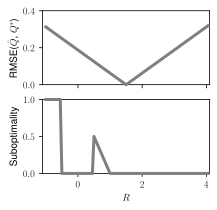

In [68]:
fig, axes = plt.subplots(2,1, sharex=True, figsize=(3,3))
plt.sca(axes[0])
plt.plot(R_list, rmse_list, '-', c='tab:gray', lw=3, markersize=3, zorder=10, clip_on=False)
plt.ylim(0, 0.4)
plt.ylabel('RMSE($\hat{Q}$, $Q^*$)')

plt.sca(axes[1])
plt.plot(R_list, suboptimality_list, '-', c='tab:gray', lw=3, markersize=3, zorder=10, clip_on=False)
plt.ylabel('Suboptimality')
plt.ylim(0, 1)

# axes[1].fill_between([1,5.1], [0,0], [1,1], facecolor='gray', alpha=0.2)
# axes[0].plot(2, 0, 'o', c='w', mec='tab:red', markersize=6, zorder=10, clip_on=False)
# axes[0].annotate('Unbiased', (2,0), (2,0.12), c='tab:red', ha='center')
# axes[0].annotate('Biased', (0,0.25), (2,0.3), c='tab:gray', ha='center', arrowprops=dict(arrowstyle='->', color='k'))
# axes[0].annotate('Biased', (4,0.25), (2,0.3), c='tab:gray', ha='center', arrowprops=dict(arrowstyle='->', color='k'))
# axes[1].annotate('Optimal', (1,0.5), (3,0.5), c='k', va='center', ha='center', arrowprops=dict(arrowstyle='->'))
# axes[1].annotate('Optimal', (5,0.5), (3,0.5), c='k', va='center', ha='center', arrowprops=dict(arrowstyle='->'))

plt.xlim(-1.1, 4.1)
plt.xlabel('$R$')
# plt.savefig('figures/bandit_rmse_subopt.pdf', bbox_inches='tight')
plt.show()

### Bandits - Realizability

In [74]:
# Sweep through different R values
R_list = np.arange(-3, 4.1, 0.05)

rmse_list = []
suboptimality_list = []

for R_i in R_list:

    ###
    # 2D Bandit with NON-additive rewards
    ###
    env = Bandit2D((2,2), [[0,1],[0,-0.5]])
    env_flat = Env2D_Flattened(env)
    env_flat.P.update(Bandit(4, [0,1,-0.5,R_i]).P)
    nS, nA = env_flat.nS, env_flat.nA
    (P,R,X) = env_flat.featurize(factored=True)

    # True Q-values
    Q_star = algos.V2Q(env_flat, algos.policy_eval(env_flat, np.array([[1,0,0,0]]*4), gamma), gamma)

    # Linear approx Q-values
    w = (np.linalg.pinv(X) @ Q_star.reshape(-1))
    Q_star_approx = (X @ w).reshape((nS, nA))
    
    # Evaluate policy of argmax of Linear approx Q-values
    Q_star_approx_value = algos.policy_eval(env_flat, algos.greedy_policy(Q_star_approx, None), gamma)
    
    # Save results
    rmse_list.append(np.sqrt(np.mean(np.square(Q_star_approx - Q_star))))
    suboptimality_list.append(algos.policy_eval(env_flat, algos.greedy_policy(Q_star, None), gamma)[0] \
        - algos.policy_eval(env_flat, algos.greedy_policy(Q_star_approx, None), gamma)[0])

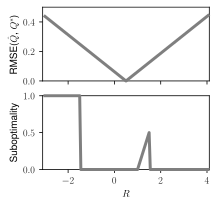

In [75]:
fig, axes = plt.subplots(2,1, sharex=True, figsize=(3,3))
plt.sca(axes[0])
plt.plot(R_list, rmse_list, '-', c='tab:gray', lw=3, markersize=3, zorder=10, clip_on=False)
plt.ylim(0, 0.5)
plt.ylabel('RMSE($\hat{Q}$, $Q^*$)')

plt.sca(axes[1])
plt.plot(R_list, suboptimality_list, '-', c='tab:gray', lw=3, markersize=3, zorder=10, clip_on=False)
plt.ylabel('Suboptimality')
plt.ylim(0, 1)

# axes[1].fill_between([1,5.1], [0,0], [1,1], facecolor='gray', alpha=0.2)
# axes[0].plot(2, 0, 'o', c='w', mec='tab:red', markersize=6, zorder=10, clip_on=False)
# axes[0].annotate('Unbiased', (2,0), (2,0.12), c='tab:red', ha='center')
# axes[0].annotate('Biased', (0,0.25), (2,0.3), c='tab:gray', ha='center', arrowprops=dict(arrowstyle='->', color='k'))
# axes[0].annotate('Biased', (4,0.25), (2,0.3), c='tab:gray', ha='center', arrowprops=dict(arrowstyle='->', color='k'))
# axes[1].annotate('Optimal', (1,0.5), (3,0.5), c='k', va='center', ha='center', arrowprops=dict(arrowstyle='->'))
# axes[1].annotate('Optimal', (5,0.5), (3,0.5), c='k', va='center', ha='center', arrowprops=dict(arrowstyle='->'))

plt.xlim(-3-.1, 4.1)
plt.xlabel('$R$')
# plt.savefig('figures/bandit_rmse_subopt.pdf', bbox_inches='tight')
plt.show()

### Bandits - Realizability

In [78]:
# Sweep through different R values
R_list = np.arange(-5, 4.1, 0.05)

rmse_list = []
suboptimality_list = []

for R_i in R_list:

    ###
    # 2D Bandit with NON-additive rewards
    ###
    env = Bandit2D((2,2), [[0,1],[0,-2]])
    env_flat = Env2D_Flattened(env)
    env_flat.P.update(Bandit(4, [0,1,-2,R_i]).P)
    nS, nA = env_flat.nS, env_flat.nA
    (P,R,X) = env_flat.featurize(factored=True)

    # True Q-values
    Q_star = algos.V2Q(env_flat, algos.policy_eval(env_flat, np.array([[1,0,0,0]]*4), gamma), gamma)

    # Linear approx Q-values
    w = (np.linalg.pinv(X) @ Q_star.reshape(-1))
    Q_star_approx = (X @ w).reshape((nS, nA))
    
    # Evaluate policy of argmax of Linear approx Q-values
    Q_star_approx_value = algos.policy_eval(env_flat, algos.greedy_policy(Q_star_approx, None), gamma)
    
    # Save results
    rmse_list.append(np.sqrt(np.mean(np.square(Q_star_approx - Q_star))))
    suboptimality_list.append(algos.policy_eval(env_flat, algos.greedy_policy(Q_star, None), gamma)[0] \
        - algos.policy_eval(env_flat, algos.greedy_policy(Q_star_approx, None), gamma)[0])

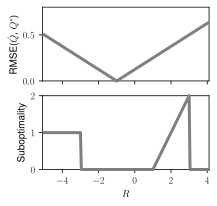

In [80]:
fig, axes = plt.subplots(2,1, sharex=True, figsize=(3,3))
plt.sca(axes[0])
plt.plot(R_list, rmse_list, '-', c='tab:gray', lw=3, markersize=3, zorder=10, clip_on=False)
plt.ylim(0, 0.8)
plt.ylabel('RMSE($\hat{Q}$, $Q^*$)')

plt.sca(axes[1])
plt.plot(R_list, suboptimality_list, '-', c='tab:gray', lw=3, markersize=3, zorder=10, clip_on=False)
plt.ylabel('Suboptimality')
plt.ylim(0, 2)

# axes[1].fill_between([1,5.1], [0,0], [1,1], facecolor='gray', alpha=0.2)
# axes[0].plot(2, 0, 'o', c='w', mec='tab:red', markersize=6, zorder=10, clip_on=False)
# axes[0].annotate('Unbiased', (2,0), (2,0.12), c='tab:red', ha='center')
# axes[0].annotate('Biased', (0,0.25), (2,0.3), c='tab:gray', ha='center', arrowprops=dict(arrowstyle='->', color='k'))
# axes[0].annotate('Biased', (4,0.25), (2,0.3), c='tab:gray', ha='center', arrowprops=dict(arrowstyle='->', color='k'))
# axes[1].annotate('Optimal', (1,0.5), (3,0.5), c='k', va='center', ha='center', arrowprops=dict(arrowstyle='->'))
# axes[1].annotate('Optimal', (5,0.5), (3,0.5), c='k', va='center', ha='center', arrowprops=dict(arrowstyle='->'))

plt.xlim(-5-.1, 4.1)
plt.xlabel('$R$')
# plt.savefig('figures/bandit_rmse_subopt.pdf', bbox_inches='tight')
plt.show()

### Bandits - Learning

True Q-values
[0. 1. 1. 2.]

Linear approx w
[-0.  1.  1. -0.  0.  1.  0.  1. -0.  0. -0.  0.]
Linear approx Q-values
[-0.  1.  1.  2.]

One-hot LSPI - model-based
w
[0. 1. 1. 2. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0.]
Q
[0. 1. 1. 2.]



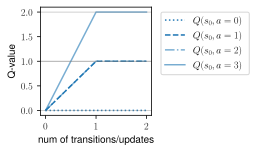

Factored LSPI - model-based
w
[ 0.  1.  1.  0. -0.  1.  0.  1. -0.  0.  0. -0.]
Q
[0. 1. 1. 2.]



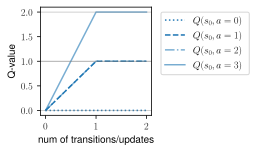

Standard Q-learning
[0.      0.99999 0.99998 2.     ]


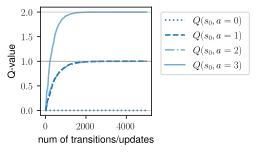

Factored Q-learning
[0.00021 1.00006 1.00004 1.99989]


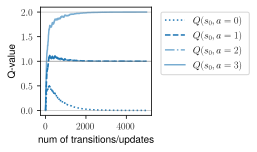

In [27]:
###
# 2D Bandit with additive rewards
###
env = Bandit2D((2,2), [[0,1],[0,1]])
env_flat = Env2D_Flattened(env)
nS, nA = env_flat.nS, env_flat.nA
(P0, R0, X0) = env_flat.featurize(factored=False)
(P , R , X ) = env_flat.featurize(factored=True)
π_dummy = np.array([[1,0,0,0]]*4) # dummy policy for 2x2 state space

# True Q-values
Q_star_true = algos.V2Q(env_flat, algos.policy_eval(env_flat, π_dummy, gamma), gamma)
print('True Q-values')
print(Q_star_true[0,:])
print()

# Linear approx Q-values
w = (np.linalg.pinv(X) @ Q_star_true.reshape(-1))
Q_star_approx = (X @ w).reshape((nS, nA))
print('Linear approx w')
print(w)
print('Linear approx Q-values')
print(Q_star_approx[0,:])
print()

# One-hot LSPI - model-based
w, w_history = LSPI_onehot(env_flat, gamma)
print('One-hot LSPI - model-based')
print('w')
print(w)
print('Q')
print((X0 @ w).reshape((env.nS, env.nA))[0,:])
print(flush=True)
fig, ax = plt.subplots(figsize=(2,2))
plot_Q_learning_curves(np.array([X0 @ w for w in w_history]).reshape((-1, nS, nA))[:,:1,:])
for q in Q_star_true[0,:]:
    plt.axhline(q, lw=0.75, c='gray', alpha=0.5)
plt.show()

# Factored LSPI - model-based
w, w_history = LSPI_factored(env_flat, gamma)
print('Factored LSPI - model-based')
print('w')
print(w)
print('Q')
print((X @ w).reshape((env.nS, env.nA))[0,:])
print(flush=True)
fig, ax = plt.subplots(figsize=(2,2))
plot_Q_learning_curves(np.array([X @ w for w in w_history]).reshape((-1, nS, nA))[:,:1,:])
for q in Q_star_true[0,:]:
    plt.axhline(q, lw=0.75, c='gray', alpha=0.5)
plt.show()

# Q-learning orig action
print('Standard Q-learning', flush=True)
Q_star, metadata = algos.qlearn(
    env_flat, n_ep, algos.epsilon_greedy_policy, 
    gamma=gamma, alpha=0.01, epsilon=epsilon,
    save_Q=1, use_tqdm=False,
)
V_star = Q_star.max(axis=1)
print(Q_star[0,:], flush=True)
fig, ax = plt.subplots(figsize=(2,2))
plot_Q_learning_curves(metadata['Qs'][:,:1,:])
for q in Q_star_true[0,:]:
    plt.axhline(q, lw=0.75, c='gray', alpha=0.5)
plt.show()

# Factored Q-learning
print('Factored Q-learning', flush=True)
Q_star, metadata = qlearn_factored(
    env_flat, n_ep, algos.epsilon_greedy_policy, 
    gamma=gamma, alpha=0.01, epsilon=epsilon,
    save_Q=1, use_tqdm=False,
)
Q_star_values = np.array([Q_star[s].reshape(-1) for s in range(env.nS)])
V_star = Q_star_values.max(axis=1)
print(Q_star_values[0,:])

Q_values_history = np.array([np.array([Q[s].reshape(-1) for s in range(env.nS)[:1]]) for Q in metadata['Qs']])
fig, ax = plt.subplots(figsize=(2,2))
plot_Q_learning_curves(Q_values_history[:,:,:])
for q in Q_star_true[0,:]:
    plt.axhline(q, lw=0.75, c='gray', alpha=0.5)
plt.show()

True Q-values
[0. 1. 1. 4.]

Linear approx w
[-0.5  2.   2.   0.   0.   0.   0.   1.  -0.   0.   0.  -0. ]
Linear approx Q-values
[-0.5  1.5  1.5  3.5]

One-hot LSPI - model-based
w
[-0.  1.  1.  4. -0. -0. -0. -0. -0.  1. -0.  1. -0. -0. -0. -0.]
Q
[-0.  1.  1.  4.]



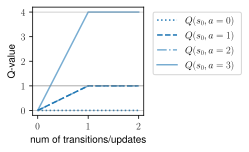

Factored LSPI - model-based
w
[-0.5  2.   2.  -0.  -0.   0.   0.   1.  -0.   0.  -0.  -0. ]
Q
[-0.5  1.5  1.5  3.5]



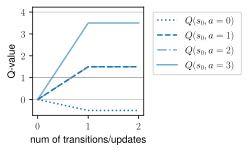

Standard Q-learning
[0.      0.99999 0.99998 4.     ]


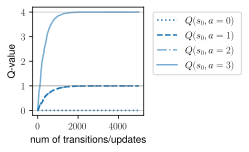

Factored Q-learning
[-0.54211  1.57164  1.51944  3.63319]


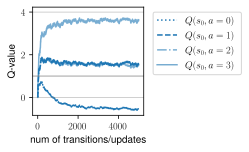

In [29]:
###
# 2D Bandit with non-additive rewards
###
R_changed = 4

env = Bandit2D((2,2), [[0,1],[0,1]])
env_flat = Env2D_Flattened(env)
env_flat.P.update(Bandit(4, [0,1,1,R_changed]).P)
nS, nA = env_flat.nS, env_flat.nA
(P0, R0, X0) = env_flat.featurize(factored=False)
(P , R , X ) = env_flat.featurize(factored=True)
π_dummy = np.array([[1,0,0,0]]*4) # dummy policy for 2x2 state space

# True Q-values
Q_star_true = algos.V2Q(env_flat, algos.policy_eval(env_flat, π_dummy, gamma), gamma)
print('True Q-values')
print(Q_star_true[0,:])
print()

# Linear approx Q-values
w = (np.linalg.pinv(X) @ Q_star_true.reshape(-1))
Q_star_approx = (X @ w).reshape((nS, nA))
print('Linear approx w')
print(w)
print('Linear approx Q-values')
print(Q_star_approx[0,:])
print()

# One-hot LSPI - model-based
w, w_history = LSPI_onehot(env_flat, gamma)
print('One-hot LSPI - model-based')
print('w')
print(w)
print('Q')
print((X0 @ w).reshape((env.nS, env.nA))[0,:])
print(flush=True)
fig, ax = plt.subplots(figsize=(2,2))
plot_Q_learning_curves(np.array([X0 @ w for w in w_history]).reshape((-1, nS, nA))[:,:1,:])
for q in Q_star_true[0,:]:
    plt.axhline(q, lw=0.75, c='gray', alpha=0.5)
plt.show()

# Factored LSPI - model-based
w, w_history = LSPI_factored(env_flat, gamma)
print('Factored LSPI - model-based')
print('w')
print(w)
print('Q')
print((X @ w).reshape((env.nS, env.nA))[0,:])
print(flush=True)
fig, ax = plt.subplots(figsize=(2,2))
plot_Q_learning_curves(np.array([X @ w for w in w_history]).reshape((-1, nS, nA))[:,:1,:])
for q in Q_star_true[0,:]:
    plt.axhline(q, lw=0.75, c='gray', alpha=0.5)
plt.show()

# Q-learning orig action
print('Standard Q-learning', flush=True)
Q_star, metadata = algos.qlearn(
    env_flat, n_ep, algos.epsilon_greedy_policy, 
    gamma=gamma, alpha=0.01, epsilon=epsilon,
    save_Q=1, use_tqdm=False,
)
V_star = Q_star.max(axis=1)
print(Q_star[0,:], flush=True)
fig, ax = plt.subplots(figsize=(2,2))
plot_Q_learning_curves(metadata['Qs'][:,:1,:])
for q in Q_star_true[0,:]:
    plt.axhline(q, lw=0.75, c='gray', alpha=0.5)
plt.show()

# Factored Q-learning
print('Factored Q-learning', flush=True)
Q_star, metadata = qlearn_factored(
    env_flat, n_ep, algos.epsilon_greedy_policy, 
    gamma=gamma, alpha=0.01, epsilon=epsilon,
    save_Q=1, use_tqdm=False,
)
Q_star_values = np.array([Q_star[s].reshape(-1) for s in range(env.nS)])
V_star = Q_star_values.max(axis=1)
print(Q_star_values[0,:])

Q_values_history = np.array([np.array([Q[s].reshape(-1) for s in range(env.nS)[:1]]) for Q in metadata['Qs']])
fig, ax = plt.subplots(figsize=(2,2))
plot_Q_learning_curves(Q_values_history[:,:,:])
for q in Q_star_true[0,:]:
    plt.axhline(q, lw=0.75, c='gray', alpha=0.5)
plt.show()

True Q-values
[0. 1. 1. 1.]

Linear approx w
[ 0.25  0.5   0.5   0.    0.    0.    0.    1.   -0.    0.   -0.    0.  ]
Linear approx Q-values
[0.25 0.75 0.75 1.25]

One-hot LSPI - model-based
w
[-0.  1.  1.  1. -0. -0. -0. -0. -0.  1. -0.  1. -0. -0. -0. -0.]
Q
[-0.  1.  1.  1.]



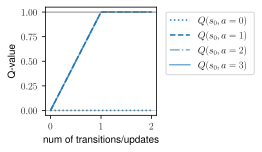

Factored LSPI - model-based
w
[ 0.25  0.5   0.5  -0.    0.    0.    0.    1.   -0.    0.   -0.   -0.  ]
Q
[0.25 0.75 0.75 1.25]



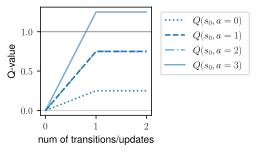

Standard Q-learning
[0.      0.99999 0.99998 1.     ]


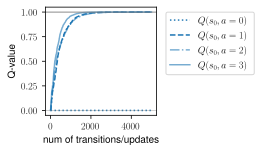

Factored Q-learning
[0.27137 0.71427 0.74035 1.18324]


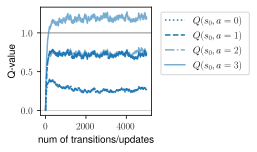

In [31]:
###
# 2D Bandit with non-additive rewards
###
R_changed = 1

env = Bandit2D((2,2), [[0,1],[0,1]])
env_flat = Env2D_Flattened(env)
env_flat.P.update(Bandit(4, [0,1,1,R_changed]).P)
nS, nA = env_flat.nS, env_flat.nA
(P0, R0, X0) = env_flat.featurize(factored=False)
(P , R , X ) = env_flat.featurize(factored=True)
π_dummy = np.array([[1,0,0,0]]*4) # dummy policy for 2x2 state space

# True Q-values
Q_star_true = algos.V2Q(env_flat, algos.policy_eval(env_flat, π_dummy, gamma), gamma)
print('True Q-values')
print(Q_star_true[0,:])
print()

# Linear approx Q-values
w = (np.linalg.pinv(X) @ Q_star_true.reshape(-1))
Q_star_approx = (X @ w).reshape((nS, nA))
print('Linear approx w')
print(w)
print('Linear approx Q-values')
print(Q_star_approx[0,:])
print()

# One-hot LSPI - model-based
w, w_history = LSPI_onehot(env_flat, gamma)
print('One-hot LSPI - model-based')
print('w')
print(w)
print('Q')
print((X0 @ w).reshape((env.nS, env.nA))[0,:])
print(flush=True)
fig, ax = plt.subplots(figsize=(2,2))
plot_Q_learning_curves(np.array([X0 @ w for w in w_history]).reshape((-1, nS, nA))[:,:1,:])
for q in Q_star_true[0,:]:
    plt.axhline(q, lw=0.75, c='gray', alpha=0.5)
plt.show()

# Factored LSPI - model-based
w, w_history = LSPI_factored(env_flat, gamma)
print('Factored LSPI - model-based')
print('w')
print(w)
print('Q')
print((X @ w).reshape((env.nS, env.nA))[0,:])
print(flush=True)
fig, ax = plt.subplots(figsize=(2,2))
plot_Q_learning_curves(np.array([X @ w for w in w_history]).reshape((-1, nS, nA))[:,:1,:])
for q in Q_star_true[0,:]:
    plt.axhline(q, lw=0.75, c='gray', alpha=0.5)
plt.show()

# Q-learning orig action
print('Standard Q-learning', flush=True)
Q_star, metadata = algos.qlearn(
    env_flat, n_ep, algos.epsilon_greedy_policy, 
    gamma=gamma, alpha=0.01, epsilon=epsilon,
    save_Q=1, use_tqdm=False,
)
V_star = Q_star.max(axis=1)
print(Q_star[0,:], flush=True)
fig, ax = plt.subplots(figsize=(2,2))
plot_Q_learning_curves(metadata['Qs'][:,:1,:])
for q in Q_star_true[0,:]:
    plt.axhline(q, lw=0.75, c='gray', alpha=0.5)
plt.show()

# Factored Q-learning
print('Factored Q-learning', flush=True)
Q_star, metadata = qlearn_factored(
    env_flat, n_ep, algos.epsilon_greedy_policy, 
    gamma=gamma, alpha=0.01, epsilon=epsilon,
    save_Q=1, use_tqdm=False,
)
Q_star_values = np.array([Q_star[s].reshape(-1) for s in range(env.nS)])
V_star = Q_star_values.max(axis=1)
print(Q_star_values[0,:])

Q_values_history = np.array([np.array([Q[s].reshape(-1) for s in range(env.nS)[:1]]) for Q in metadata['Qs']])
fig, ax = plt.subplots(figsize=(2,2))
plot_Q_learning_curves(Q_values_history[:,:,:])
for q in Q_star_true[0,:]:
    plt.axhline(q, lw=0.75, c='gray', alpha=0.5)
plt.show()

True Q-values
[0. 1. 1. 0.]

Linear approx w
[ 0.5  0.  -0.   0.   0.   0.   0.   1.  -0.   0.  -0.   0. ]
Linear approx Q-values
[0.5 0.5 0.5 0.5]

One-hot LSPI - model-based
w
[-0.  1.  1. -0. -0. -0. -0. -0. -0.  1. -0.  1. -0. -0. -0. -0.]
Q
[-0.  1.  1. -0.]



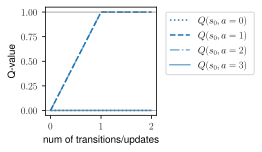

Factored LSPI - model-based
w
[ 0.5 -0.  -0.  -0.   0.   0.   0.   1.  -0.   0.  -0.  -0. ]
Q
[0.5 0.5 0.5 0.5]



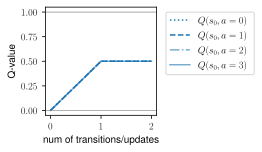

Standard Q-learning
[0.      1.      0.99998 0.     ]


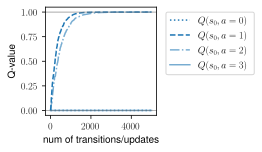

Factored Q-learning
[0.46367 0.44953 0.45426 0.44012]


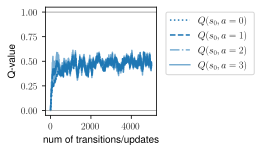

In [32]:
###
# 2D Bandit with non-additive rewards
###
R_changed = 0

env = Bandit2D((2,2), [[0,1],[0,1]])
env_flat = Env2D_Flattened(env)
env_flat.P.update(Bandit(4, [0,1,1,R_changed]).P)
nS, nA = env_flat.nS, env_flat.nA
(P0, R0, X0) = env_flat.featurize(factored=False)
(P , R , X ) = env_flat.featurize(factored=True)
π_dummy = np.array([[1,0,0,0]]*4) # dummy policy for 2x2 state space

# True Q-values
Q_star_true = algos.V2Q(env_flat, algos.policy_eval(env_flat, π_dummy, gamma), gamma)
print('True Q-values')
print(Q_star_true[0,:])
print()

# Linear approx Q-values
w = (np.linalg.pinv(X) @ Q_star_true.reshape(-1))
Q_star_approx = (X @ w).reshape((nS, nA))
print('Linear approx w')
print(w)
print('Linear approx Q-values')
print(Q_star_approx[0,:])
print()

# One-hot LSPI - model-based
w, w_history = LSPI_onehot(env_flat, gamma)
print('One-hot LSPI - model-based')
print('w')
print(w)
print('Q')
print((X0 @ w).reshape((env.nS, env.nA))[0,:])
print(flush=True)
fig, ax = plt.subplots(figsize=(2,2))
plot_Q_learning_curves(np.array([X0 @ w for w in w_history]).reshape((-1, nS, nA))[:,:1,:])
for q in Q_star_true[0,:]:
    plt.axhline(q, lw=0.75, c='gray', alpha=0.5)
plt.show()

# Factored LSPI - model-based
w, w_history = LSPI_factored(env_flat, gamma)
print('Factored LSPI - model-based')
print('w')
print(w)
print('Q')
print((X @ w).reshape((env.nS, env.nA))[0,:])
print(flush=True)
fig, ax = plt.subplots(figsize=(2,2))
plot_Q_learning_curves(np.array([X @ w for w in w_history]).reshape((-1, nS, nA))[:,:1,:])
for q in Q_star_true[0,:]:
    plt.axhline(q, lw=0.75, c='gray', alpha=0.5)
plt.show()

# Q-learning orig action
print('Standard Q-learning', flush=True)
Q_star, metadata = algos.qlearn(
    env_flat, n_ep, algos.epsilon_greedy_policy, 
    gamma=gamma, alpha=0.01, epsilon=epsilon,
    save_Q=1, use_tqdm=False,
)
V_star = Q_star.max(axis=1)
print(Q_star[0,:], flush=True)
fig, ax = plt.subplots(figsize=(2,2))
plot_Q_learning_curves(metadata['Qs'][:,:1,:])
for q in Q_star_true[0,:]:
    plt.axhline(q, lw=0.75, c='gray', alpha=0.5)
plt.show()

# Factored Q-learning
print('Factored Q-learning', flush=True)
Q_star, metadata = qlearn_factored(
    env_flat, n_ep, algos.epsilon_greedy_policy, 
    gamma=gamma, alpha=0.01, epsilon=epsilon,
    save_Q=1, use_tqdm=False,
)
Q_star_values = np.array([Q_star[s].reshape(-1) for s in range(env.nS)])
V_star = Q_star_values.max(axis=1)
print(Q_star_values[0,:])

Q_values_history = np.array([np.array([Q[s].reshape(-1) for s in range(env.nS)[:1]]) for Q in metadata['Qs']])
fig, ax = plt.subplots(figsize=(2,2))
plot_Q_learning_curves(Q_values_history[:,:,:])
for q in Q_star_true[0,:]:
    plt.axhline(q, lw=0.75, c='gray', alpha=0.5)
plt.show()

True Q-values
[ 0.  1.  1. -1.]

Linear approx w
[ 0.75 -0.5  -0.5   0.    0.    0.    0.    1.   -0.    0.   -0.    0.  ]
Linear approx Q-values
[ 0.75  0.25  0.25 -0.25]

One-hot LSPI - model-based
w
[-0.  1.  1. -1. -0. -0. -0. -0. -0.  1. -0.  1. -0. -0. -0. -0.]
Q
[-0.  1.  1. -1.]



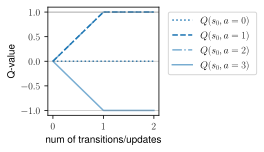

Factored LSPI - model-based
w
[ 0.75 -0.5  -0.5   0.    0.   -0.    0.    1.   -0.    0.   -0.   -0.  ]
Q
[ 0.75  0.25  0.25 -0.25]



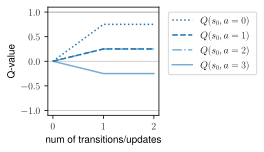

Standard Q-learning
[ 0.       1.       0.99998 -0.99999]


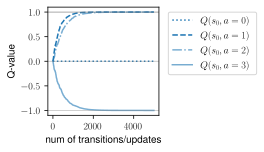

Factored Q-learning
[ 0.53949  0.20497  0.13913 -0.19538]


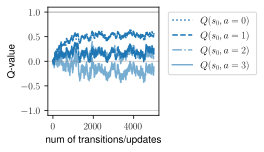

In [33]:
###
# 2D Bandit with non-additive rewards
###
R_changed = -1

env = Bandit2D((2,2), [[0,1],[0,1]])
env_flat = Env2D_Flattened(env)
env_flat.P.update(Bandit(4, [0,1,1,R_changed]).P)
nS, nA = env_flat.nS, env_flat.nA
(P0, R0, X0) = env_flat.featurize(factored=False)
(P , R , X ) = env_flat.featurize(factored=True)
π_dummy = np.array([[1,0,0,0]]*4) # dummy policy for 2x2 state space

# True Q-values
Q_star_true = algos.V2Q(env_flat, algos.policy_eval(env_flat, π_dummy, gamma), gamma)
print('True Q-values')
print(Q_star_true[0,:])
print()

# Linear approx Q-values
w = (np.linalg.pinv(X) @ Q_star_true.reshape(-1))
Q_star_approx = (X @ w).reshape((nS, nA))
print('Linear approx w')
print(w)
print('Linear approx Q-values')
print(Q_star_approx[0,:])
print()

# One-hot LSPI - model-based
w, w_history = LSPI_onehot(env_flat, gamma)
print('One-hot LSPI - model-based')
print('w')
print(w)
print('Q')
print((X0 @ w).reshape((env.nS, env.nA))[0,:])
print(flush=True)
fig, ax = plt.subplots(figsize=(2,2))
plot_Q_learning_curves(np.array([X0 @ w for w in w_history]).reshape((-1, nS, nA))[:,:1,:])
for q in Q_star_true[0,:]:
    plt.axhline(q, lw=0.75, c='gray', alpha=0.5)
plt.show()

# Factored LSPI - model-based
w, w_history = LSPI_factored(env_flat, gamma)
print('Factored LSPI - model-based')
print('w')
print(w)
print('Q')
print((X @ w).reshape((env.nS, env.nA))[0,:])
print(flush=True)
fig, ax = plt.subplots(figsize=(2,2))
plot_Q_learning_curves(np.array([X @ w for w in w_history]).reshape((-1, nS, nA))[:,:1,:])
for q in Q_star_true[0,:]:
    plt.axhline(q, lw=0.75, c='gray', alpha=0.5)
plt.show()

# Q-learning orig action
print('Standard Q-learning', flush=True)
Q_star, metadata = algos.qlearn(
    env_flat, n_ep, algos.epsilon_greedy_policy, 
    gamma=gamma, alpha=0.01, epsilon=epsilon,
    save_Q=1, use_tqdm=False,
)
V_star = Q_star.max(axis=1)
print(Q_star[0,:], flush=True)
fig, ax = plt.subplots(figsize=(2,2))
plot_Q_learning_curves(metadata['Qs'][:,:1,:])
for q in Q_star_true[0,:]:
    plt.axhline(q, lw=0.75, c='gray', alpha=0.5)
plt.show()

# Factored Q-learning
print('Factored Q-learning', flush=True)
Q_star, metadata = qlearn_factored(
    env_flat, n_ep, algos.epsilon_greedy_policy, 
    gamma=gamma, alpha=0.01, epsilon=epsilon,
    save_Q=1, use_tqdm=False,
)
Q_star_values = np.array([Q_star[s].reshape(-1) for s in range(env.nS)])
V_star = Q_star_values.max(axis=1)
print(Q_star_values[0,:])

Q_values_history = np.array([np.array([Q[s].reshape(-1) for s in range(env.nS)[:1]]) for Q in metadata['Qs']])
fig, ax = plt.subplots(figsize=(2,2))
plot_Q_learning_curves(Q_values_history[:,:,:])
for q in Q_star_true[0,:]:
    plt.axhline(q, lw=0.75, c='gray', alpha=0.5)
plt.show()